<a href="https://colab.research.google.com/github/mimaimarima/DIODE_outdoor_with_MiDaS/blob/main/DIODE_outdoor_with_MiDaS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [45]:
"""
Додаток 1: „DIODE outdoor Depth Estimation with MiDaS"
Дипломски труд на тема „Мерење на растојание во слика"
Област: Дигитално процесирање на слика

Ментор: Доц. Д-р. Бојана Величковска
Студент: Мима Војновска со индекс 132/2021

Факултетот за електротехника и информациски технологии (ФЕИТ) при Универзитетот „Св. Кирил и Методиј“ во Скопје
Јуни 2025

Опис:
Во оваа скрипта е прикажан систем за автоматизирано вчитување, обработка, предвидување, споредба и евалуација на длабочински мапи за слики
користејќи ја MiDaS архитектурата за монокуларна проценка на длабочина. Скриптата е прилагодена за анализа на слики од DIODE податочното множество,
со фокус на надворешни сцени.
"""

# Конфигурација
!pip install -q imageio torchsummary gdown
!pip install -q torch torchvision matplotlib opencv-python
!pip install timm

# Превзенање на податочно множество директно од авторите
import os
import shutil

def setup_diode_dataset():
    try:
        !wget -q https://diode-dataset.s3.amazonaws.com/val.tar.gz
        !tar -xzf val.tar.gz
        !mkdir -p diode_dataset/train
        !mv val diode_dataset/train/outdoor
        return "/content/diode_dataset/train"


    except Exception as e:
        print(f"Could not download dataset: {e}")
        return None

DIODE_PATH = setup_diode_dataset()

if DIODE_PATH and os.path.exists(DIODE_PATH):
    print(f"Dataset ready at: {DIODE_PATH}")
    !ls {DIODE_PATH}
else:
    raise RuntimeError("Could not load the dataset. Please check your internet connection.")



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.0/52.0 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 33.9 MB/s eta 0:00:00
mv: cannot move 'val' to 'diode_dataset/train/outdoor/val': Directory not empty
Dataset ready at: /content/diode_dataset/train
outdoor


In [66]:
## Импорти
import cv2
import numpy as np
import torch
import matplotlib.pyplot as plt
import pandas as pd
from collections import deque
import seaborn as sns  # Add this import
import torch
import numpy as np
from collections import deque
import pandas as pd


## Константи
METRIC_STABILITY_WINDOW = 20  ## Број примероци за проверка на стабилност
STABILITY_THRESHOLD = 0.01    ## Релативен праг за стабилизација на метрики
MIN_SAMPLES = 50              ## Минимален број примероци пред проверка за стабилност
MAX_SAMPLES = 500             ## Максимален број на примероци за ограничувања на Colab


In [67]:
## Пронаоѓање на достапни примероци кои содржат RGB слика, длабочинска мапа и маска со редослед
!pip install natsort
from natsort import natsorted

def find_available_samples(base_path):
    samples = []
    for root, _, files in sorted(os.walk(base_path)):
        if 'indoors' in root.lower():
            continue
        for file in sorted(files):
            if file.endswith('.png') and not any(x in file for x in ['_depth', '_mask']):
                base_name = file[:-4]
                rgb_path = os.path.join(root, file)
                depth_path = os.path.join(root, f"{base_name}_depth.npy")
                mask_path = os.path.join(root, f"{base_name}_depth_mask.npy")
                if all(os.path.exists(p) for p in [rgb_path, depth_path, mask_path]):
                    samples.append({
                        'rgb': rgb_path,
                        'depth': depth_path,
                        'mask': mask_path
                    })
    return natsorted(samples, key=lambda x: x['rgb'])   ## Сортирање по пат на датотека за конзистентност

In [68]:
## Проверка на стабилност на метрика со праг

def check_metric_stability(metric_history):
    if len(metric_history) < METRIC_STABILITY_WINDOW:
        return False

    ## Пресметка на релативна промена на метрика
    recent_vals = np.array(metric_history)[-METRIC_STABILITY_WINDOW:]
    means = np.mean(recent_vals, axis=0)
    stds = np.std(recent_vals, axis=0)

    ## Нормализација на std со mean за добивање на релативна промена
    relative_changes = np.abs(stds / (means + 1e-6))
    return np.all(relative_changes < STABILITY_THRESHOLD)


In [69]:
## Вчитување и валидација на примерок

def load_and_validate_sample(sample):

    try:
        img = cv2.imread(sample['rgb'])
        if img is None:
            raise ValueError(f"Failed to load image: {sample['rgb']}")
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        depth = np.load(sample['depth'])
        mask = np.load(sample['mask'])
        if depth.ndim == 3 and depth.shape[2] == 1:
            depth = depth.squeeze()
        if img.shape[:2] != depth.shape or img.shape[:2] != mask.shape:
            raise ValueError(
                f"Shape mismatch in {os.path.basename(sample['rgb'])}: "
                f"Image {img.shape[:2]}, Depth {depth.shape}, Mask {mask.shape}"
            )
        unique_mask_values = np.unique(mask)
        if not np.array_equal(unique_mask_values, [0, 1]):
            raise ValueError(
                f"Invalid mask values in {os.path.basename(sample['rgb'])}: "
                f"Found {unique_mask_values}, expected [0, 1]"
            )
        return img, depth, mask
    except Exception as e:
        print(f"Error loading sample {sample['rgb']}: {str(e)}")
        return None, None, None

In [70]:
## Предвидување со MiDas - Референца 1

def midas_prediction(img, model, transform, device):
    try:
        input_tensor = transform(img).to(device)
        if input_tensor.ndim == 3:
            input_tensor = input_tensor.unsqueeze(0) ## Midas бара (1,C,H,W) batch тензор на влез

        with torch.no_grad():
            prediction = model(input_tensor)
            if isinstance(prediction, (list, tuple)):
                prediction = prediction[0]
            prediction = torch.nn.functional.interpolate(
                prediction.unsqueeze(1) if prediction.ndim == 3 else prediction,
                size=img.shape[:2],
                mode="bicubic",
                align_corners=False
            ).squeeze().cpu().numpy()
        return prediction
    except Exception as e:
        print(f"MiDaS processing failed: {str(e)}")
        return None

In [71]:
## Процесирање на примерок

def process_sample(sample, model, transform, device):

    try:
        img = cv2.imread(sample['rgb'])
        if img is None:
            raise ValueError(f"Failed to load image: {sample['rgb']}")
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        depth = np.load(sample['depth']).squeeze()
        mask = np.load(sample['mask']).squeeze()
        if img.shape[:2] != depth.shape or img.shape[:2] != mask.shape:
            raise ValueError("Shape mismatch between image/depth/mask")

        prediction = midas_prediction(img, model, transform, device)
        if prediction is None:
            return None

        pred_depth = prediction.copy()

        valid_mask = (depth > 0) & (mask > 0)
        if np.sum(valid_mask) > 100:  ## Проверка на минимален број валидни пиксели во маската (min = 100)

            ## Скалирање по медијана
            gt_median = np.median(depth[valid_mask])
            pred_median = np.median(pred_depth[valid_mask])

            ## IQR скалирање
            gt_iqr = np.percentile(depth[valid_mask], 75) - np.percentile(depth[valid_mask], 25)
            pred_iqr = np.percentile(pred_depth[valid_mask], 75) - np.percentile(pred_depth[valid_mask], 25)

            ## Комбиниран фактор на скалирање
            scale_factor = (gt_median/pred_median) * (gt_iqr/pred_iqr)
            pred_depth = pred_depth * scale_factor

        return {
            'filename': os.path.basename(sample['rgb']),
            'image': img,
            'true_depth': depth,
            'pred_depth': pred_depth,
            'mask': mask
        }
    except Exception as e:
        print(f"Error processing {sample.get('rgb', 'unknown')}: {str(e)}")
        return None


In [72]:
## Скалирање и поместување на длабочинските мапи

def scale_and_shift_align(pred, gt, mask):
    np.random.seed(42)
    pred = pred.reshape(gt.shape)
    pred_masked = pred[mask].flatten()
    gt_masked = gt[mask].flatten()

    ## Отстранување на outliers

    gt_median = np.median(gt_masked[gt_masked > 0])
    gt_mad = 1.4826 * np.median(np.abs(gt_masked[gt_masked > 0] - gt_median))

    valid = (gt_masked > 0) & (gt_masked < gt_median + 3*gt_mad) & \
            (pred_masked > 0) & (pred_masked < np.percentile(pred_masked, 95)) & \
            (~np.isnan(pred_masked)) & (~np.isinf(pred_masked))

    if np.sum(valid) < 50:
        return pred

    try:
        ## Линеарно усогласување
        A_linear = np.vstack([pred_masked[valid], np.ones_like(pred_masked[valid])]).T
        b_linear = gt_masked[valid]
        scale_linear, shift_linear = np.linalg.lstsq(A_linear, b_linear, rcond=None)[0]
        aligned_linear = scale_linear * pred + shift_linear

        ## Усогласување во логаритамски простор
        log_pred = np.log(pred_masked[valid] + 1e-6)
        log_gt = np.log(gt_masked[valid] + 1e-6)
        A_log = np.vstack([log_pred, np.ones_like(log_pred)]).T
        b_log = log_gt
        scale_log, shift_log = np.linalg.lstsq(A_log, b_log, rcond=None)[0]
        aligned_log = np.exp(shift_log) * (pred ** scale_log)

        ## Избор на подобро усогласување спрема RMSE
        rmse_linear = np.sqrt(np.mean((aligned_linear[mask][valid] - gt_masked[valid])**2))
        rmse_log = np.sqrt(np.mean((aligned_log[mask][valid] - gt_masked[valid])**2))

        return aligned_linear if rmse_linear < rmse_log else aligned_log
    except:
        return pred


In [73]:
## Пресметка на метрики

def compute_depth_metrics(true_depth, pred_depth, mask):

    if pred_depth.ndim == 1:
        pred_depth = pred_depth.reshape(true_depth.shape)

    true = true_depth[mask]
    pred = pred_depth[mask]

    ## Филтрирање на екстремни вредности
    valid = (true > 0) & (true < np.percentile(true[true > 0], 99.5)) & \
            (~np.isnan(pred)) & (~np.isinf(pred)) & \
            (pred > 0) & (pred < np.percentile(pred[pred > 0], 99.5))

    true = true[valid]
    pred = pred[valid]

    if len(true) == 0:
        return {"AbsRel": np.nan, "RMSE": np.nan, "MAE": np.nan, "a1": np.nan}

    ## Кратење на вредности до ранг спрема сензор со кој е сниман DIODE
    MIN_DEPTH = 0.6
    MAX_DEPTH = 100.0  ## Иако сензорот е до 350 метри, вредностите над 100 метри не се релевантни
    true = np.clip(true, MIN_DEPTH, MAX_DEPTH)
    pred = np.clip(pred, MIN_DEPTH, MAX_DEPTH)

    eps = 1e-6
    abs_rel = np.mean(np.abs(true - pred) / (true + eps))
    rmse = np.sqrt(np.mean((true - pred) ** 2))
    mae = np.mean(np.abs(true - pred))
    thresh = np.maximum(true / (pred + eps), pred / (true + eps))
    a1 = (thresh < 1.25).mean()

    return {
        "AbsRel": abs_rel,
        "RMSE": rmse,
        "MAE": mae,
        "a1": a1
    }


In [74]:
## Визуелизација на резултати

def visualize_comparison(result, aligned_pred=None):

    fig, axs = plt.subplots(1, 4, figsize=(24, 6))

    ## RGB Слика
    axs[0].imshow(result['image'])
    axs[0].set_title('RGB Image')
    axs[0].axis('off')

    ## Вистинска длабочинска мапа
    gt_depth = np.ma.masked_where(result['mask'] == 0, result['true_depth'])
    gt_vmax = np.percentile(result['true_depth'][result['mask'] > 0], 99.5)
    im = axs[1].imshow(gt_depth, cmap='plasma', vmin=0, vmax=gt_vmax)
    axs[1].set_title('Ground Truth Depth')
    axs[1].axis('off')
    plt.colorbar(im, ax=axs[1], fraction=0.046, pad=0.04)

    ## Предвидување од MiDaS
    pred = np.ma.masked_where(result['mask'] == 0, result['pred_depth'])
    pred_vmax = np.percentile(result['pred_depth'][result['mask'] > 0], 99.5)
    im = axs[2].imshow(pred, cmap='plasma', vmin=0, vmax=pred_vmax)
    axs[2].set_title('MiDaS Prediction')
    axs[2].axis('off')
    plt.colorbar(im, ax=axs[2], fraction=0.046, pad=0.04)

    ## Усогласено предвидување
    if aligned_pred is not None:
        aligned = np.ma.masked_where(result['mask'] == 0, aligned_pred)
        aligned_vmax = np.percentile(aligned_pred[result['mask'] > 0], 99.5)
        im = axs[3].imshow(aligned, cmap='plasma', vmin=0, vmax=aligned_vmax)
        axs[3].set_title('Aligned MiDaS Prediction')
        axs[3].axis('off')
        plt.colorbar(im, ax=axs[3], fraction=0.046, pad=0.04)

    plt.suptitle(result['filename'])
    plt.tight_layout()
    plt.show()

In [75]:
## Статистичка анализа

def enhanced_statistical_analysis(df):

    print("\n=== Enhanced Statistical Analysis ===")

    ## Основна статистика
    print("\nBasic Statistics:")
    print(df.describe().to_string(float_format="{:0.4f}".format))

    ## Најдобри и најлоши примероци
    for metric in ['AbsRel', 'RMSE', 'MAE', 'a1']:
        best = df.loc[df[metric].idxmin() if metric != 'a1' else df[metric].idxmax()]
        worst = df.loc[df[metric].idxmax() if metric != 'a1' else df[metric].idxmin()]

        print(f"\nBest {metric}: {best['filename']} ({best[metric]:.4f})")
        print(f"Worst {metric}: {worst['filename']} ({worst[metric]:.4f})")

    ## Анализа на дистрибуција на грешка
    print("\nError Distribution Analysis:")
    for metric in ['AbsRel', 'RMSE', 'MAE']:
        q25, q75 = df[metric].quantile([0.25, 0.75])
        iqr = q75 - q25
        print(f"{metric}: IQR = {iqr:.4f} (25%: {q25:.4f}, 75%: {q75:.4f})")

def plot_metric_distributions(df):
  """Plot distributions of all metrics"""
  fig, axs = plt.subplots(2, 2, figsize=(12, 10))
  metrics = ['AbsRel', 'RMSE', 'MAE', 'a1']

  for i, metric in enumerate(metrics):
      ax = axs[i//2, i%2]
      sns.histplot(df[metric], kde=True, ax=ax)
      ax.set_title(f'Distribution of {metric}')
      ax.set_xlabel(metric)

  plt.tight_layout()
  plt.show()



In [76]:
def main():
    DIODE_PATH = "/content/diode_dataset"
    DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

    ## Поставување на random seeds за повторување
    torch.manual_seed(42)
    np.random.seed(42)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    ## Вчитување на модел
    midas = torch.hub.load("intel-isl/MiDaS", "DPT_Large").to(DEVICE).eval()
    transform = torch.hub.load("intel-isl/MiDaS", "transforms").dpt_transform
    transform.transforms[0].mean = [0.485, 0.456, 0.406]
    transform.transforms[0].std = [0.229, 0.224, 0.225]

    ## Превземање на примероци
    all_samples = find_available_samples(os.path.join(DIODE_PATH, "train/outdoor"))
    results = []
    metric_history = deque(maxlen=METRIC_STABILITY_WINDOW)
    should_stop = False

    print(f"\nStarting processing of up to {MAX_SAMPLES} samples...")

    for i, sample in enumerate(all_samples[:MAX_SAMPLES]):
        if should_stop:
            print(f"\nMetrics stabilized after {i} samples")
            break

        result = process_sample(sample, midas, transform, DEVICE)
        if result is None:
            continue

        try:
            aligned_pred = scale_and_shift_align(
                result['pred_depth'],
                result['true_depth'],
                result['mask'].astype(bool))

            metrics = compute_depth_metrics(
                result['true_depth'],
                aligned_pred,
                result['mask'].astype(bool))

            metrics['filename'] = result['filename']
            results.append((result, metrics))

            ## Складирање на метрики за проверка на стабилност
            metric_values = [metrics[k] for k in ['AbsRel', 'RMSE', 'MAE', 'a1'] if not np.isnan(metrics[k])]
            if len(metric_values) == 4:
                metric_history.append(metric_values)

            print(f"\nSample {i+1}/{min(len(all_samples), MAX_SAMPLES)}: {result['filename']}")
            for k, v in metrics.items():
                if k != 'filename':
                    print(f"{k}: {v:.4f}")

            ## Проверка на стабилност по минимален број примероци
            if i >= MIN_SAMPLES and check_metric_stability(metric_history):
                should_stop = True

        except Exception as e:
            print(f"Failed to process {sample.get('rgb', 'unknown')}: {str(e)}")

    ## Процесирање и приказ на крајни резултати
    if results:
      all_metrics = [m for _, m in results]
      df = pd.DataFrame(all_metrics)
      valid_metrics = df.dropna()

      enhanced_statistical_analysis(valid_metrics)
      plot_metric_distributions(valid_metrics)

      print(f"\nFinal Results ({len(valid_metrics)} valid samples processed):")
      print("\nAggregate Metrics:")
      print(valid_metrics.drop(columns='filename').mean().to_string(float_format="{:0.4f}".format))

      results_df = save_results_to_csv(results)

      print("\nMetric Stability Analysis:")
      if metric_history:
          recent_metrics = np.array(metric_history)
          for i, metric in enumerate(['AbsRel', 'RMSE', 'MAE', 'a1']):
              vals = recent_metrics[:, i]
              print(f"{metric}:")
              print(f"  Last {METRIC_STABILITY_WINDOW} samples:")
              print(f"  Mean = {np.mean(vals):.4f}")
              print(f"  Std = {np.std(vals):.4f}")
              print(f"  Relative Change = {np.std(vals)/np.mean(vals):.4f}")

      ## Визуелизација на 3 примероци
      visualize_samples = min(3, len(results))
      print(f"\nVisualizing first {visualize_samples} samples...")
      for result, metrics in results[:visualize_samples]:

          aligned_pred = scale_and_shift_align(
              result['pred_depth'],
              result['true_depth'],
              result['mask'].astype(bool))
          visualize_comparison(result, aligned_pred)


In [77]:
def save_results_to_csv(results, csv_path="midas_diode_results.csv"):

    rows = []
    for result, metrics in results:
        row = {
            'filename': metrics['filename'],
            **metrics,
            'image_width': result['image'].shape[1],
            'image_height': result['image'].shape[0]
        }
        rows.append(row)

    df = pd.DataFrame(rows)

    df.to_csv(csv_path, index=False)
    print(f"\nSaved results to {csv_path}")
    return df


Using cache found in /root/.cache/torch/hub/intel-isl_MiDaS_master
Using cache found in /root/.cache/torch/hub/intel-isl_MiDaS_master



Starting processing of up to 500 samples...

Sample 1/500: 00022_00193_outdoor_000_000.png
AbsRel: 0.3212
RMSE: 7.8690
MAE: 4.3030
a1: 0.5801


<ipython-input-72-3955611175>:34: RuntimeWarning: divide by zero encountered in power
  aligned_log = np.exp(shift_log) * (pred ** scale_log)
<ipython-input-72-3955611175>:34: RuntimeWarning: invalid value encountered in power
  aligned_log = np.exp(shift_log) * (pred ** scale_log)



Sample 2/500: 00022_00193_outdoor_000_020.png
AbsRel: 0.4990
RMSE: 5.9173
MAE: 4.7042
a1: 0.7149

Sample 3/500: 00022_00193_outdoor_000_040.png
AbsRel: 0.1349
RMSE: 3.6394
MAE: 2.2551
a1: 0.9365

Sample 4/500: 00022_00193_outdoor_010_010.png
AbsRel: 0.5224
RMSE: 4.6118
MAE: 3.6539
a1: 0.5471

Sample 5/500: 00022_00193_outdoor_010_030.png
AbsRel: 0.1200
RMSE: 3.6032
MAE: 2.1492
a1: 0.9223

Sample 6/500: 00022_00193_outdoor_020_000.png
AbsRel: 0.2496
RMSE: 8.4350
MAE: 3.7211
a1: 0.7172

Sample 7/500: 00022_00193_outdoor_030_020.png
AbsRel: 0.5028
RMSE: 5.6678
MAE: 4.0789
a1: 0.6723

Sample 8/500: 00022_00193_outdoor_030_040.png
AbsRel: 0.1839
RMSE: 4.2046
MAE: 2.9437
a1: 0.8768

Sample 9/500: 00022_00193_outdoor_040_000.png
AbsRel: 0.1295
RMSE: 2.4315
MAE: 0.8201
a1: 0.8608

Sample 10/500: 00022_00193_outdoor_050_010.png
AbsRel: 0.1867
RMSE: 3.8254
MAE: 2.0893
a1: 0.7273

Sample 11/500: 00022_00193_outdoor_050_030.png
AbsRel: 0.2738
RMSE: 3.9961
MAE: 3.1671
a1: 0.6833

Sample 12/500: 00

/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:4779: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)



Sample 264/500: 00023_00198_outdoor_080_000.png
AbsRel: nan
RMSE: nan
MAE: nan
a1: nan

Sample 265/500: 00023_00198_outdoor_080_030.png
AbsRel: 0.0723
RMSE: 4.3201
MAE: 2.3216
a1: 0.9015

Sample 266/500: 00023_00198_outdoor_090_010.png
AbsRel: 0.2567
RMSE: 5.4948
MAE: 3.6190
a1: 0.5815

Sample 267/500: 00023_00198_outdoor_100_000.png
AbsRel: 0.3469
RMSE: 9.3075
MAE: 4.8627
a1: 0.5589

Sample 268/500: 00023_00198_outdoor_190_000.png
AbsRel: nan
RMSE: nan
MAE: nan
a1: nan

Sample 269/500: 00023_00198_outdoor_190_020.png
AbsRel: 0.0997
RMSE: 3.8686
MAE: 1.3442
a1: 0.8763

Sample 270/500: 00023_00198_outdoor_200_010.png
AbsRel: 0.2159
RMSE: 1.4750
MAE: 1.0557
a1: 0.7137

Sample 271/500: 00023_00198_outdoor_210_000.png
AbsRel: 0.2009
RMSE: 4.1628
MAE: 2.3735
a1: 0.6701

Sample 272/500: 00023_00198_outdoor_220_010.png
AbsRel: 0.1167
RMSE: 1.9043
MAE: 1.3203
a1: 0.9097

Sample 273/500: 00023_00198_outdoor_230_000.png
AbsRel: 0.0539
RMSE: 1.8255
MAE: 0.6799
a1: 0.9700

Sample 274/500: 00023_0

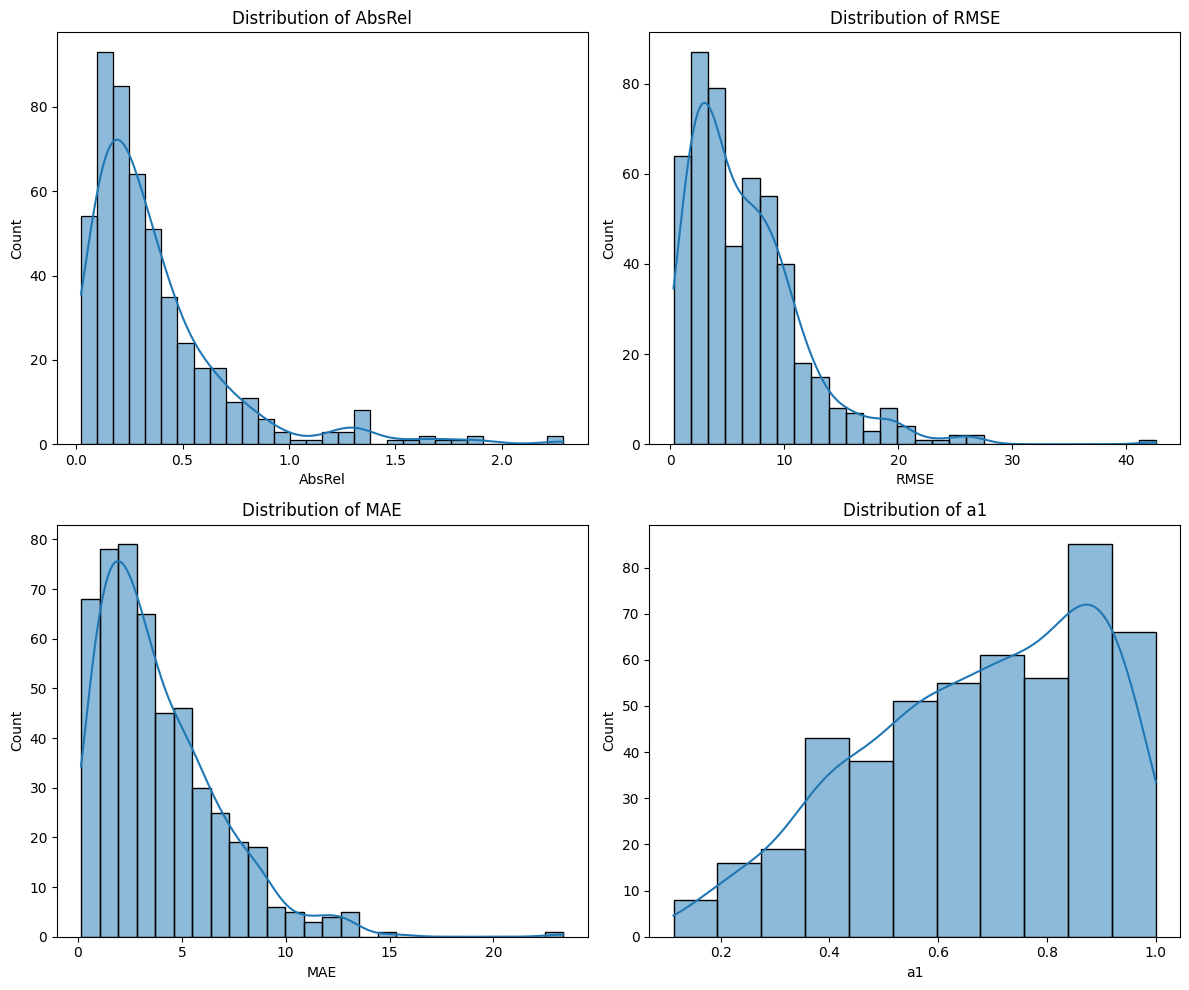


Final Results (498 valid samples processed):

Aggregate Metrics:
AbsRel   0.3677
RMSE     6.5637
MAE      3.8640
a1       0.6761

Saved results to midas_diode_results.csv

Metric Stability Analysis:
AbsRel:
  Last 20 samples:
  Mean = 0.8203
  Std = 0.4461
  Relative Change = 0.5438
RMSE:
  Last 20 samples:
  Mean = 9.3643
  Std = 2.9984
  Relative Change = 0.3202
MAE:
  Last 20 samples:
  Mean = 5.9546
  Std = 2.4955
  Relative Change = 0.4191
a1:
  Last 20 samples:
  Mean = 0.4262
  Std = 0.1829
  Relative Change = 0.4291

Visualizing first 3 samples...


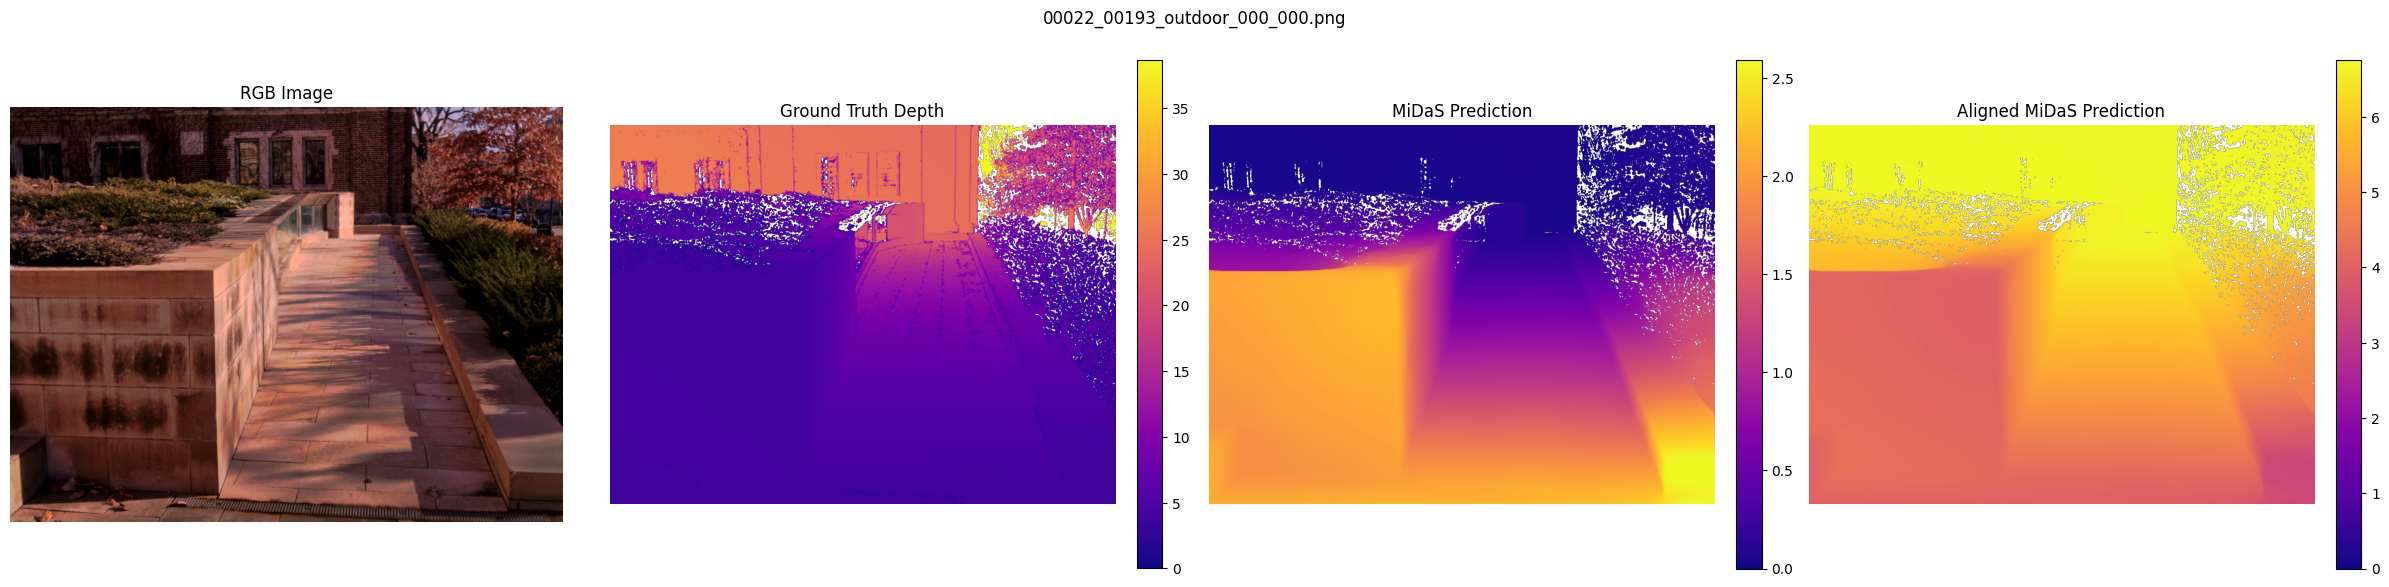

<ipython-input-72-3955611175>:34: RuntimeWarning: divide by zero encountered in power
  aligned_log = np.exp(shift_log) * (pred ** scale_log)
<ipython-input-72-3955611175>:34: RuntimeWarning: invalid value encountered in power
  aligned_log = np.exp(shift_log) * (pred ** scale_log)


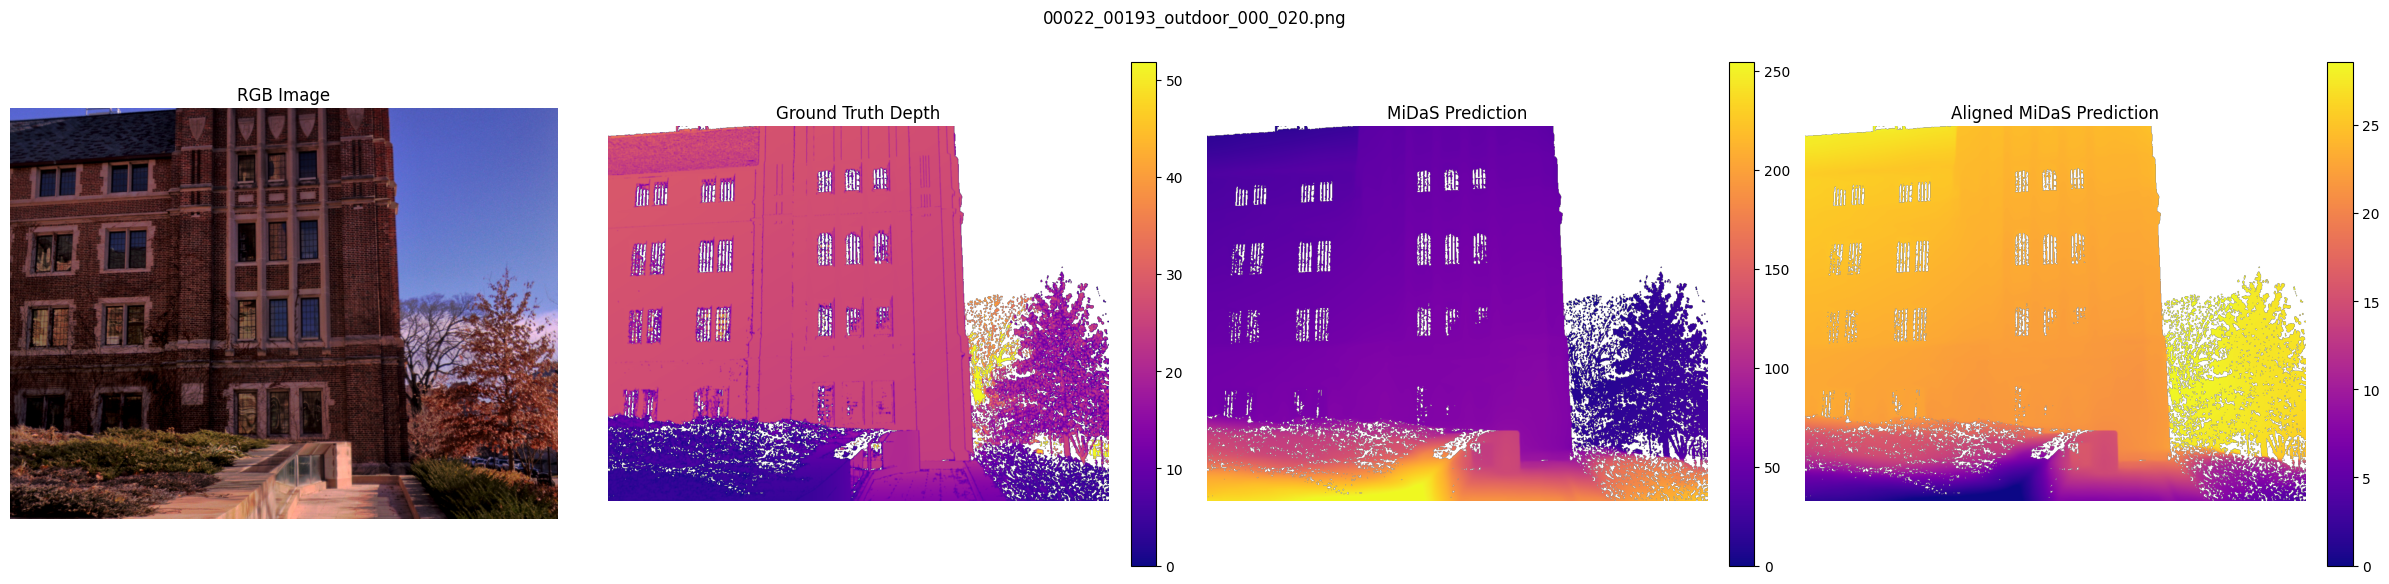

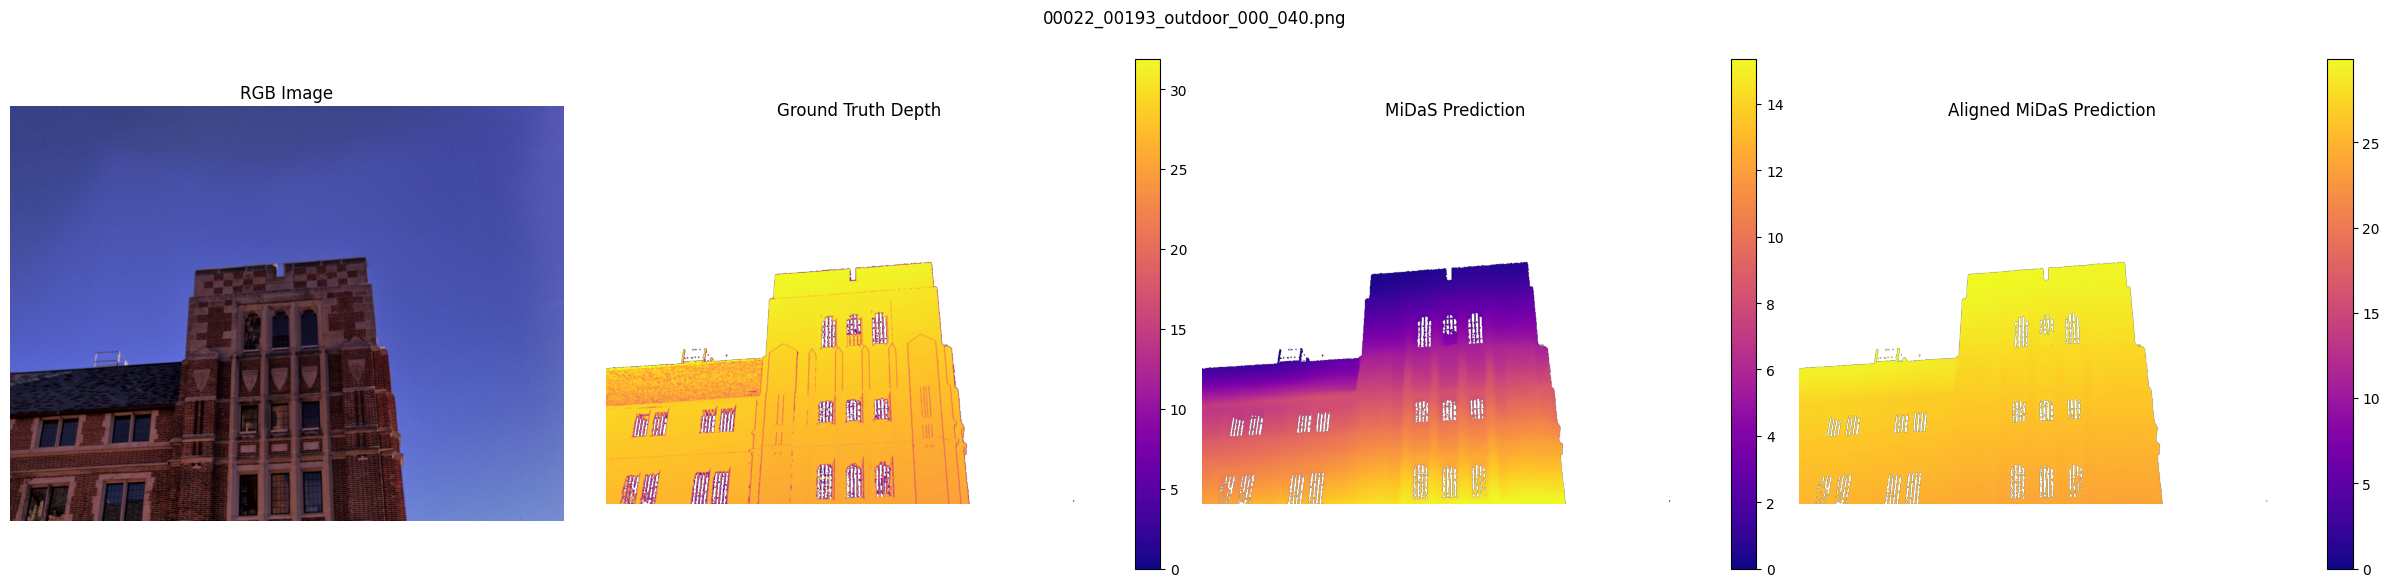

In [78]:
if __name__ == "__main__":
    main()


In [93]:
reference = {
    "author": "René Ranftl, Alexey Bochkovskiy, Vladlen Koltun",
    "title": "Vision Transformers for Dense Prediction",
    "journal": "CoRR",
    "volume": "abs/2103.13413",
    "year": 2021,
    "url": "https://arxiv.org/abs/2103.13413",
    "eprinttype": "arXiv",
    "eprint": "2103.13413"
}

# Референца 1